In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import animation 

In [2]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


In [8]:
device = torch.device("mps")

In [9]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)   # 입력 (t, x)
        self.fc2 = nn.Linear(20, 30)
        self.fc3 = nn.Linear(30, 50)
        self.fc4 = nn.Linear(50, 30)
        self.fc5 = nn.Linear(30, 20)
        self.fc6 = nn.Linear(20, 1)   # 출력 u(t, x)
        
    def forward(self, tx):
        x = torch.tanh(self.fc1(tx))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        u = self.fc6(x)
        return u

In [10]:
# 2. 편미분 계산 함수
def gradients(u, x):
        return autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

In [11]:
# 3. PINN 손실 함수 정의
def pinn_loss(model, tx, nu):
    # 네트워크의 출력 u(t, x)
    u_pred = model(tx)
    
    # t와 x에 대한 1차 및 2차 편미분 계산
    grad_1st_tensor = gradients(u_pred, tx) # 1차 미분 텐서
    grad_2nd_tensor = gradients(grad_1st_tensor, tx) # 2차 미분 텐서
    u_t = grad_1st_tensor[:,0:1]
    u_x = grad_1st_tensor[:,1:2]
    u_xx = grad_2nd_tensor[:,0:1]
    
    # Burgers 방정식의 잔차 계산
    f = u_t + u_pred * u_x - nu * u_xx
    return torch.mean(f**2)  # 물리 손실 (잔차의 제곱 평균)

In [12]:
# 4. 데이터 준비 (임의의 초기 조건과 경계 조건)
def initial_condition(x):
    return -torch.sin(torch.pi * x)

def boundary_condition(t):
    return torch.zeros_like(t)

In [13]:
# 훈련 데이터 생성
t = torch.linspace(0, 1, 100, device = device).view(-1, 1)
x = torch.linspace(-1, 1, 100, device = device).view(-1, 1)
tx = torch.cartesian_prod(t.view(-1), x.view(-1))  # 시간과 공간의 조합 (t, x)
tx.requires_grad = True  # 편미분 계산을 위한 설정

# 초기 및 경계 조건 설정
u_0 = initial_condition(x)
u_bc_left = boundary_condition(t)
u_bc_right = boundary_condition(t)

In [25]:
# 5. 모델 학습
model = PINN().to(device)
optimizer = torch.optim.LBFGS(model.parameters(), lr = 0.1, max_iter = 10, max_eval = 10)

# 점성 계수 nu 설정
nu = 0.01 / torch.pi



def closure():
    optimizer.zero_grad()
    loss_pde = pinn_loss(model, tx, nu)
    
    u_pred_0 = model(torch.cat([torch.zeros_like(x), x], dim=1))
    loss_ic = torch.mean((u_pred_0 - u_0)**2)
    
    u_pred_bc_left = model(torch.cat([t, -torch.ones_like(t)], dim=1))
    u_pred_bc_right = model(torch.cat([t, torch.ones_like(t)], dim=1))
    loss_bc = torch.mean((u_pred_bc_left - u_bc_left)**2) + torch.mean((u_pred_bc_right - u_bc_right)**2)
    
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    
    return loss


for epoch in range(1000):
    loss = optimizer.step(closure)
    #if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.5046963095664978
Epoch 1, Loss: 0.45894476771354675
Epoch 2, Loss: 0.4411093294620514
Epoch 3, Loss: 0.42862680554389954
Epoch 4, Loss: 0.410737544298172
Epoch 5, Loss: 0.40484124422073364
Epoch 6, Loss: 0.39406177401542664
Epoch 7, Loss: 0.3474108874797821
Epoch 8, Loss: 0.2795069217681885
Epoch 9, Loss: 0.2236427515745163
Epoch 10, Loss: 0.2004622519016266
Epoch 11, Loss: 0.1749756634235382
Epoch 12, Loss: 0.16428981721401215
Epoch 13, Loss: 0.16199715435504913
Epoch 14, Loss: 0.159959614276886
Epoch 15, Loss: 0.15814858675003052
Epoch 16, Loss: 0.15698161721229553
Epoch 17, Loss: 0.15567755699157715
Epoch 18, Loss: 0.15464898943901062
Epoch 19, Loss: 0.15367057919502258
Epoch 20, Loss: 0.15209896862506866
Epoch 21, Loss: 0.1495276242494583
Epoch 22, Loss: 0.14509236812591553
Epoch 23, Loss: 0.1417979747056961
Epoch 24, Loss: 0.1382201462984085
Epoch 25, Loss: 0.13514694571495056
Epoch 26, Loss: 0.13302622735500336
Epoch 27, Loss: 0.13017840683460236
Epoch 28, Loss: 

In [82]:
# 6. 결과 예측
u_pred = model(tx).detach().view(100, 100)

In [89]:
t_25x = torch.concat([torch.ones_like(x)*0.25, x],dim=1)
t_50x = torch.concat([torch.ones_like(x)*0.50, x],dim=1)
t_75x = torch.concat([torch.ones_like(x)*0.75, x],dim=1)
t_25u_pred = model(t_25x)
t_50u_pred = model(t_50x)
t_75u_pred = model(t_75x)

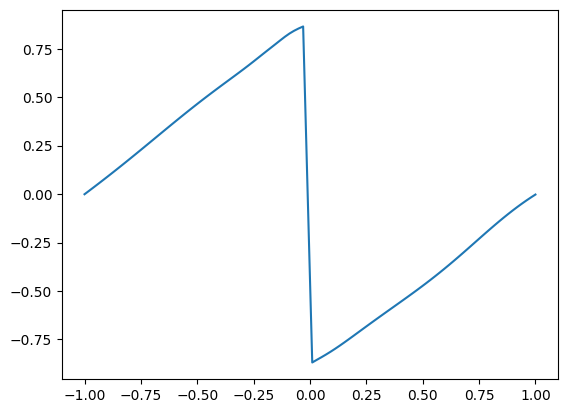

In [93]:
plt.plot(x.cpu().detach(), t_75u_pred.cpu().detach())

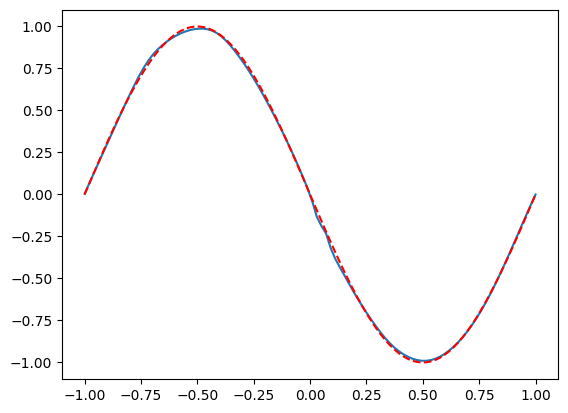

In [28]:
plt.plot(x.cpu().detach(), u_pred[0].cpu().detach())
plt.plot(x.cpu().detach(), initial_condition(x).cpu().detach(),  "r--")

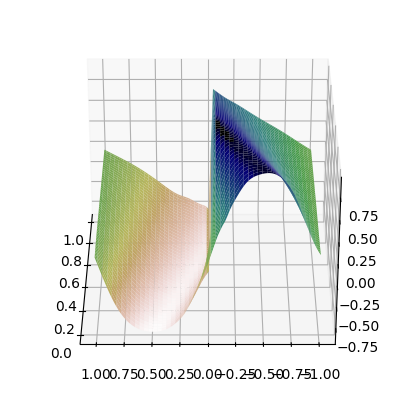

In [24]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 5), 
                        subplot_kw={"projection":"3d"})
axs.plot_surface(tx[:,0:1].cpu().detach().numpy().reshape(100,100), tx[:,1:2].cpu().detach().numpy().reshape(100,100), model(tx).cpu().view(100,100).detach().numpy(),  # 3D scatter plot
               alpha=1, cmap=cm.gist_earth_r)
axs.view_init(30,180)

/var/folders/kc/d2lhvgyd1t965xbp02fsq_9h0000gn/T/ipykernel_19901/2687074699.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  numerator = -2 * nu * np.pi * np.sin(np.pi * x)
/var/folders/kc/d2lhvgyd1t965xbp02fsq_9h0000gn/T/ipykernel_19901/2687074699.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denominator = np.exp((np.pi**2) * nu * t) + np.cos(np.pi * x)


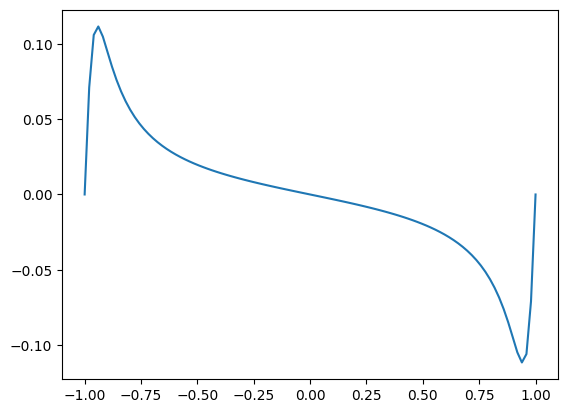

In [71]:
nu = 0.01/torch.pi

# 정확한 해 함수 (Analytic solution)
def analytic_solution(x, t, nu):
    numerator = -2 * nu * np.pi * np.sin(np.pi * x)
    denominator = np.exp((np.pi**2) * nu * t) + np.cos(np.pi * x)
    return numerator / denominator

# 정확한 해 계산
u_exact = analytic_solution(x.cpu().reshape(-1), 0.5, nu)
plt.plot(x.cpu().reshape(-1),u_exact)